# About

In this notebook I look to use linear regression to predict rent prices using the housing dataset. This notebook transitions between through the machine learning cycle; starting with the data, which was obtained via Kaggle. We then move onto the investigative/ data prep stage and finally move onto the conclusion.

# Contents



[Import libraries](#1)

[Data prep/investigation](#2)

[Model training](#3)

[References](#4)

[bookmark](#-1)








# Import libraries

<a id='1'></a>

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

# Data prep/investigation

Import csv file into DF and print first rows for examination, also look at data types.

<a id ='2'></a>



In [2]:
df = pd.read_csv ('House_Rent_Dataset.csv')

print(df.head())

    Posted On  BHK   Rent  Size            Floor    Area Type  \
0  2022-05-18    2  10000  1100  Ground out of 2   Super Area   
1  2022-05-13    2  20000   800       1 out of 3   Super Area   
2  2022-05-16    2  17000  1000       1 out of 3   Super Area   
3  2022-07-04    2  10000   800       1 out of 2   Super Area   
4  2022-05-09    2   7500   850       1 out of 2  Carpet Area   

              Area Locality     City Furnishing Status  Tenant Preferred  \
0                    Bandel  Kolkata       Unfurnished  Bachelors/Family   
1  Phool Bagan, Kankurgachi  Kolkata    Semi-Furnished  Bachelors/Family   
2   Salt Lake City Sector 2  Kolkata    Semi-Furnished  Bachelors/Family   
3               Dumdum Park  Kolkata       Unfurnished  Bachelors/Family   
4             South Dum Dum  Kolkata       Unfurnished         Bachelors   

   Bathroom Point of Contact  
0         2    Contact Owner  
1         1    Contact Owner  
2         1    Contact Owner  
3         1    Contact Owner

In [3]:
print(len(df))

4746


In [4]:
print(df.dtypes)

Posted On            object
BHK                   int64
Rent                  int64
Size                  int64
Floor                object
Area Type            object
Area Locality        object
City                 object
Furnishing Status    object
Tenant Preferred     object
Bathroom              int64
Point of Contact     object
dtype: object


In [5]:
pd.isnull(df).sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [6]:
for column in df:
    unique_vals = np.unique(df[column])
    nr_values = len(unique_vals)
    if nr_values < 10:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature Posted On :81
The number of values for feature BHK :6 -- [1 2 3 4 5 6]
The number of values for feature Rent :243
The number of values for feature Size :615
The number of values for feature Floor :480
The number of values for feature Area Type :3 -- ['Built Area' 'Carpet Area' 'Super Area']
The number of values for feature Area Locality :2235
The number of values for feature City :6 -- ['Bangalore' 'Chennai' 'Delhi' 'Hyderabad' 'Kolkata' 'Mumbai']
The number of values for feature Furnishing Status :3 -- ['Furnished' 'Semi-Furnished' 'Unfurnished']
The number of values for feature Tenant Preferred :3 -- ['Bachelors' 'Bachelors/Family' 'Family']
The number of values for feature Bathroom :8 -- [ 1  2  3  4  5  6  7 10]
The number of values for feature Point of Contact :3 -- ['Contact Agent' 'Contact Builder' 'Contact Owner']


First impressions from data:

-Rename columns to improve clarity and make them easier to work with in python
<br>-Change data types so they are easier to work with \
-It would seem that there are no missing values in the dataset
<br>-Some data is catogorical (object) and will need transforming into a number for the machine learning to work


In [7]:
#Rename columns
df.rename(columns = {'Posted On':'listed_date',
                        'BHK':'number_of_bedrooms',
                        'Rent':'rent',
                        'Size':'size',
                        'Area Type':'area_type',
                        'City':'city',
                        'Furnishing Status':'furnishing_type',
                        'Tenant Preferred':'preferred_tenant',
                        'Bathroom':'number_of_bathrooms'},inplace = True)

In [8]:
#Investigate Floor column
df['Floor']=df['Floor'].str.split('out of',expand = True)[0]

print(df['Floor'].unique())

df["Floor"] = df["Floor"].replace(['Ground'],0)
df["Floor"] = df["Floor"].replace(['Ground '],0)
df["Floor"] = df["Floor"].replace(['Upper Basement '],-1)
df["Floor"] = df["Floor"].replace(['Lower Basement '],-2)
df["Floor"] = df["Floor"].replace(['3'],'3 ')
df["Floor"] = df["Floor"].replace(['1'],'1 ')

print(df['Floor'].unique())

['Ground ' '1 ' '2 ' '4 ' '3 ' '5 ' '7 ' '8 ' 'Upper Basement ' '11 '
 'Lower Basement ' '6 ' '14 ' '43 ' '13 ' '18 ' '17 ' '9 ' '19 ' '60 '
 '34 ' '12 ' '26 ' '25 ' '53 ' '16 ' '10 ' '39 ' '32 ' '47 ' '28 ' '20 '
 '15 ' '65 ' '40 ' '37 ' '22 ' '21 ' '30 ' '35 ' '33 ' '44 ' '41 ' '46 '
 '27 ' '45 ' '48 ' '50 ' '24 ' '23 ' '29 ' '49 ' '36 ' '76 ' '3' 'Ground'
 '1']
[0 '1 ' '2 ' '4 ' '3 ' '5 ' '7 ' '8 ' -1 '11 ' -2 '6 ' '14 ' '43 ' '13 '
 '18 ' '17 ' '9 ' '19 ' '60 ' '34 ' '12 ' '26 ' '25 ' '53 ' '16 ' '10 '
 '39 ' '32 ' '47 ' '28 ' '20 ' '15 ' '65 ' '40 ' '37 ' '22 ' '21 ' '30 '
 '35 ' '33 ' '44 ' '41 ' '46 ' '27 ' '45 ' '48 ' '50 ' '24 ' '23 ' '29 '
 '49 ' '36 ' '76 ']


In [9]:
# change column datatypes
df['listed_date'] = pd.to_datetime(df.listed_date,yearfirst=True)

checking the cateogorical data to see if it should be included within the model

In [10]:
print(df.nunique())

listed_date              81
number_of_bedrooms        6
rent                    243
size                    615
Floor                    54
area_type                 3
Area Locality          2235
city                      6
furnishing_type           3
preferred_tenant          3
number_of_bathrooms       8
Point of Contact          3
dtype: int64


In [11]:
for column in df:
    if df[column].dtypes == 'object':
        print(df[column].unique())

[0 '1 ' '2 ' '4 ' '3 ' '5 ' '7 ' '8 ' -1 '11 ' -2 '6 ' '14 ' '43 ' '13 '
 '18 ' '17 ' '9 ' '19 ' '60 ' '34 ' '12 ' '26 ' '25 ' '53 ' '16 ' '10 '
 '39 ' '32 ' '47 ' '28 ' '20 ' '15 ' '65 ' '40 ' '37 ' '22 ' '21 ' '30 '
 '35 ' '33 ' '44 ' '41 ' '46 ' '27 ' '45 ' '48 ' '50 ' '24 ' '23 ' '29 '
 '49 ' '36 ' '76 ']
['Super Area' 'Carpet Area' 'Built Area']
['Bandel' 'Phool Bagan, Kankurgachi' 'Salt Lake City Sector 2' ...
 'BN Reddy Nagar' 'Godavari Homes, Quthbullapur' 'Manikonda, Hyderabad']
['Kolkata' 'Mumbai' 'Bangalore' 'Delhi' 'Chennai' 'Hyderabad']
['Unfurnished' 'Semi-Furnished' 'Furnished']
['Bachelors/Family' 'Bachelors' 'Family']
['Contact Owner' 'Contact Agent' 'Contact Builder']


In [12]:
df1 = df.drop(columns = ['Area Locality','listed_date','Floor'])
df1 = pd.get_dummies(df1)

In [13]:
print(df1.head())

   number_of_bedrooms   rent  size  number_of_bathrooms  area_type_Built Area  \
0                   2  10000  1100                    2                     0   
1                   2  20000   800                    1                     0   
2                   2  17000  1000                    1                     0   
3                   2  10000   800                    1                     0   
4                   2   7500   850                    1                     0   

   area_type_Carpet Area  area_type_Super Area  city_Bangalore  city_Chennai  \
0                      0                     1               0             0   
1                      0                     1               0             0   
2                      0                     1               0             0   
3                      0                     1               0             0   
4                      1                     0               0             0   

   city_Delhi  ...  city_Mumbai 

In [14]:
print(df1.dtypes)

number_of_bedrooms                   int64
rent                                 int64
size                                 int64
number_of_bathrooms                  int64
area_type_Built Area                 uint8
area_type_Carpet Area                uint8
area_type_Super Area                 uint8
city_Bangalore                       uint8
city_Chennai                         uint8
city_Delhi                           uint8
city_Hyderabad                       uint8
city_Kolkata                         uint8
city_Mumbai                          uint8
furnishing_type_Furnished            uint8
furnishing_type_Semi-Furnished       uint8
furnishing_type_Unfurnished          uint8
preferred_tenant_Bachelors           uint8
preferred_tenant_Bachelors/Family    uint8
preferred_tenant_Family              uint8
Point of Contact_Contact Agent       uint8
Point of Contact_Contact Builder     uint8
Point of Contact_Contact Owner       uint8
dtype: object


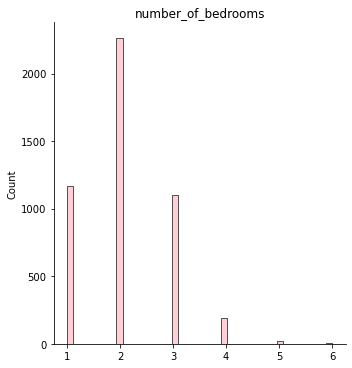

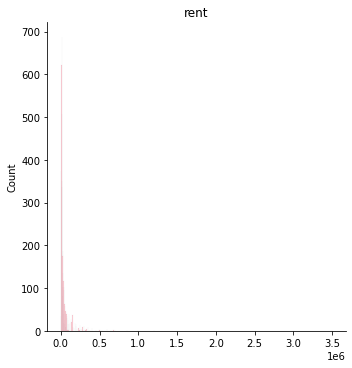

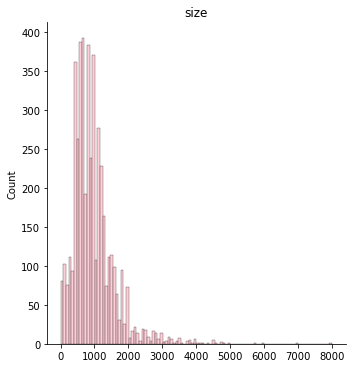

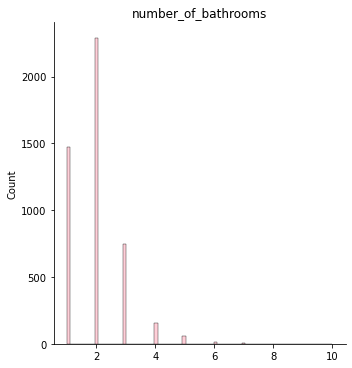

In [21]:
numeric_columns = ['number_of_bedrooms',
'rent','size','number_of_bathrooms']

for n in numeric_columns:
    x=df1[n].values
    sns.displot(x,color ='pink')
    plt.title(n)
    plt.show
    

<function matplotlib.pyplot.show(close=None, block=None)>

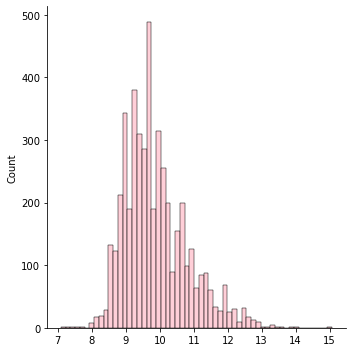

In [13]:
x = np.log(df1['rent'].values)

sns.displot(x,color ='pink')
plt.show

# bookmark










<a id ='-1'></a>

 test for normality and then remove outliers
    
talk about removing outliers, print histogtam. then use zscores 

Many models assume that the distribution of the dataset is normal. 
If the data is not normal then the assumptions that underpin the model are not valid and as such the prediction power maybe reduced.
We will carry out a couple of tests for normality:
- The shapiro test
- QQ plot

In [23]:
rent_norm = df1['rent']
rent_norm = norm.rvs(size=4746)

print(stats.shapiro(rent_norm))

ShapiroResult(statistic=0.9996647834777832, pvalue=0.6456425189971924)


C:\Users\Chris\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Figure(432x288)


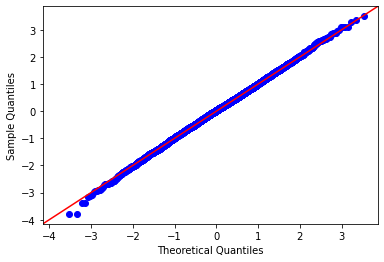

In [24]:
print(sm.qqplot(rent_norm, line='45'))


The pvalue is above .05 so we accept the null hypothesis that this data is normally distributed. The QQ plot confirms this with the data mirroring the red line. We will investigate the data for outliers, as normality can be assumed we can use this to help us.

In [25]:
z = np.abs(stats.zscore(df1['rent']))
df.drop(np.where(z > 2) [0],inplace = True)

# Model Building

<a id ='3'></a>

In [27]:
print(df.columns)

Index(['listed_date', 'number_of_bedrooms', 'rent', 'size', 'Floor',
       'area_type', 'Area Locality', 'city', 'furnishing_type',
       'preferred_tenant', 'number_of_bathrooms', 'Point of Contact'],
      dtype='object')


In [28]:
hm = df[['listed_date', 'number_of_bedrooms', 'rent', 'size', 'Floor',
       'area_type', 'Area Locality', 'city', 'furnishing_type',
       'preferred_tenant', 'number_of_bathrooms', 'Point of Contact']].corr()

In [29]:
corr = df1.corr()

AxesSubplot(0.125,0.125;0.62x0.755)


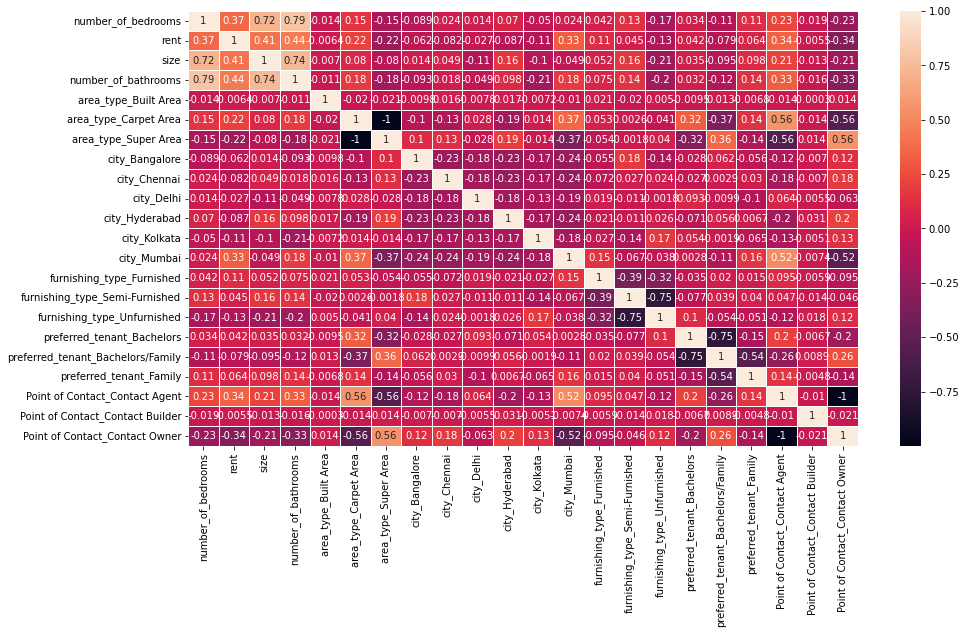

In [30]:
plt.figure(figsize=(15,8))
g = sns.heatmap(corr, annot = True, linewidths=.5)
print(g)

In [48]:

#x_train, x_test, y_train, y_test = train_test_split(df['size'], df['rent'])
# note the above is using df
#for singular regression
x_train, x_test, y_train, y_test = train_test_split(df1[['size','number_of_bedrooms','number_of_bathrooms','city_Mumbai','Point of Contact_Contact Agent']], np.log(df1['rent'])) 
#- for multiple regression


In [49]:
scale_vars = ['number_of_bedrooms', 'size', 'number_of_bathrooms','city_Mumbai','Point of Contact_Contact Agent']
scaler = MinMaxScaler()
df1[scale_vars] = scaler.fit_transform(df1[scale_vars])


In [50]:
lr=LinearRegression()
lr.fit(x_train.values, y_train.values)
prediction =lr.predict(x_train.values)
#lr.fit(x_train.values.reshape(-1,1), y_train.values)
#prediction =lr.predict(x_train.values.reshape(-1,1))

In [52]:
#r squared/accuracy
print('The r2  on the training dataset is: ',r2_score(y_train,prediction))
# The Root Mean Squared Error (RMSE)
print('The RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train,prediction)))
print('The normalised RMSE  on the training dataset is: ',sqrt(mean_squared_error(y_train,prediction))/(max(df1['rent'])-min(df1['rent'])))
# The Mean Absolute Error (MAE)
print('The MAE  on the training dataset is: ',mean_absolute_error(y_train,prediction))

print('The MAPE  on the training dataset is: ',mean_absolute_percentage_error(y_train, prediction))


The accuracy on the training dataset is:  0.7827398406845891
The r2  on the training dataset is:  0.7827398406845891
The RMSE  on the training dataset is:  0.43488763312417866
The normalised RMSE  on the training dataset is:  1.2429622531272969e-07
The MAE  on the training dataset is:  0.3243923191522246
The MAPE  on the training dataset is:  0.03285966071915508


In [55]:
print('The r2/accuracy of the test dataset is: ',r2_score(y_test, lr.predict(x_test))) 

The r2/accuracy of the test dataset is:  0.781759268573681


# bookmark
Move this as required








<a id ='5'></a>

# References

## Regression

A lot of this work builds on the work from this post: https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset/code?datasetId=2355600&sortBy=dateCreated

Using colour in jupyter: https://www.techonthenet.com/css/properties/color.php 
e.g <font color=orchid> colour
    
Using hyperlinks in jupyter: https://sebastianraschka.com/Articles/2014_ipython_internal_links.html
    
Adding new lines in markdown: https://stackoverflow.com/questions/41906199/how-to-make-a-new-line-in-a-jupyter-markdown-cell
    
Tests for normality: https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93#:~:text=For%20quick%20and%20visual%20identification,use%20the%20Shapiro%20Wilk%20test.



<a id ='4'></a>
    


# Citations

Sci-kit learn - https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html

